'''
 * Copyright (c) 2017 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

The functional form of the model is:

$$
\text{logit}[ \Pr(\text{chd}|X) ] = \theta_0 + h_1(X_1)^T \theta_1 + h_2(X_2)^T \theta_2 + \dots + h_p(X_p)^T \theta_p,
$$
where each of the $\theta_j$ are vectors of coefficients multiplying their associated vector of natural spline basis functions $h_j$.

We use four natural spline bases for each term in the model. For example, with $X_1$ representing sbp, $h_1(X_1)$ is a basis consisting of four basis functions. This actually implies three rather than two interior knots (chosen at uniform quantiles of sbp), plus two boundary knots at the extremes of the data, since we exclude the constant term from each of the $h_j$. Since famhist is a two-level factor, it is coded by a simple binary or dummy variable, and is associated with a single coefficient in the fit of the model.

More compactly, we can combine all $p$ vectors of basis functions (and the constant term) into one big vector $h(X)$, and then the model is simply:

$$
h(X)^T \theta,
$$
with the total number of parameters $df = 1 + \sum_{j=1}^p df_j$, the sum of the parameters in each component term. Each basis function is evaluated at each of the $N$ samples, resulting in an $N \times df$ basis matrix $H$.

At this point, the model is like any other linear logistic model, and the algorithms described in Section 4.4.1 apply. We carried out a backward stepwise deletion process, dropping terms from this model while preserving the group structure of each term, rather than dropping one coefficient at a time. The AIC statistic (Section 7.5) was used to drop terms, and all the terms remaining in the final model would cause AIC to increase if deleted from the model (see Table 5.1).

The covariance matrix $ \text{Cov}(\hat{\theta}) = \Sigma $ is estimated by:

$
\hat{\Sigma} = (H^T W H)^{-1},
$
where $W$ is the diagonal weight matrix from the logistic regression. Hence, the pointwise variance function $ v_j(X_j) = \text{Var}[f_j(X_j)] $ is given by:

$
v_j(X_j) = h_j(X_j)^T \hat{\Sigma}_{jj} h_j(X_j),
$
where $ \hat{\Sigma}_{jj} $ is the appropriate sub-matrix of $ \hat{\Sigma} $. The shaded region $p$ in each panel is defined by $ \hat{f_j}(X_j) \pm 2 v_j(X_j) $.

The AIC statistic is slightly more generous than the likelihood-ratio test (deviance test). Both sbp and obesity are included in this model.

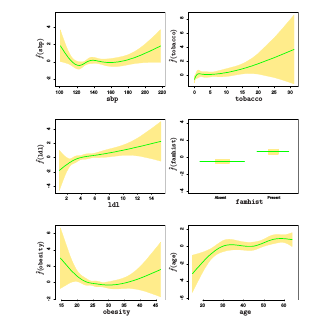
FIG.4. Fitted natural-spline functions for each of the terms in the ﬁnal model selected by the stepwise procedure. Included are pointwise standard-error bands. The rug plot at the base of each ﬁgure indicates the location of each of the sample values for that variable (jittered to break ties).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices, cr
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# Fix column names to make them valid identifiers
df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

# Add the target column (species) to the dataframe
df['species'] = iris.target

# Convert species to a binary outcome (e.g., versicolor vs. others) for logistic regression
df['species'] = df['species'].apply(lambda x: 1 if x == 1 else 0)

# Define the logistic regression formula using natural splines for continuous features
formula = 'species ~ cr(sepal_length, df=4) + cr(sepal_width, df=4) + cr(petal_length, df=4) + cr(petal_width, df=4)'

# Create the design matrices
y, X = dmatrices(formula, data=df, return_type='dataframe')

# Fit the logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Display the summary of the logistic regression model
print(result.summary())

# Plot the fitted natural splines for each of the continuous features
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, var in enumerate(['sepal_length', 'sepal_width', 'petal_length', 'petal_width']):
    ax = axes[i]
    # Generate the natural spline functions for the predictor
    X_vals = np.linspace(df[var].min(), df[var].max(), 100)
    splines = cr(X_vals, df=4)
    
    # Compute the predicted values using the fitted coefficients
    fitted_values = np.dot(splines, result.params[i+1:i+2])  # i+1 because first is the intercept term
    
    # Plot the spline
    ax.plot(X_vals, fitted_values, label=f'Fitted {var}')
    ax.set_title(f'Fitted Natural Spline for {var}')
    ax.set_xlabel(var)
    ax.set_ylabel(f'Fitted {var}')
    ax.legend()

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the dataset from a CSV file
df = pd.read_csv("iris.csv")

print(df)

    sepal_length  sepal_width  petal_length  petal_width          species
0            5.1          3.5           1.4          0.2      Iris-setosa
1            4.9          3.0           1.4          0.2      Iris-setosa
2            4.7          3.2           1.3          0.2      Iris-setosa
3            4.6          3.1           1.5          0.2      Iris-setosa
4            5.0          3.6           1.4          0.2      Iris-setosa
5            5.4          3.9           1.7          0.4      Iris-setosa
6            4.6          3.4           1.4          0.3      Iris-setosa
7            5.0          3.4           1.5          0.2      Iris-setosa
8            4.4          2.9           1.4          0.2      Iris-setosa
9            4.9          3.1           1.5          0.1      Iris-setosa
10           5.4          3.7           1.5          0.2      Iris-setosa
11           4.8          3.4           1.6          0.2      Iris-setosa
12           4.8          3.0         

Fitted theta parameters: [-1.32463512 -0.04200157 -0.00459068  0.          0.          0.
 -0.52888518 -0.25660462  0.          0.          0.         -0.2976622
 -0.00674876  0.          0.          0.         -0.02335969 -0.00164668
  0.          0.          0.        ]


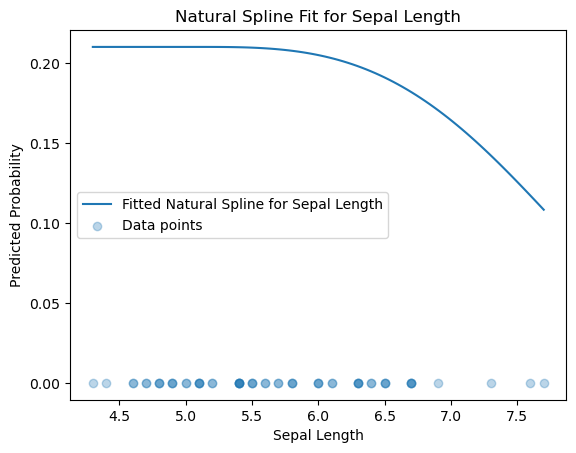

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load the dataset from a CSV file
df = pd.read_csv("iris.csv")

# Step 2: Preprocess the data
# Convert the 'species' column to binary (versicolor as 1, others as 0)
df['species'] = df['species'].apply(lambda x: 1 if x == 'versicolor' else 0)

# Step 3: Create Natural Splines
def natural_spline(x, knots, degree=3):
    """
    Create a natural cubic spline basis for input data x with given knots.
    """
    n = len(knots)
    spline_matrix = np.zeros((len(x), n + degree - 1))
    
    for i in range(len(x)):
        xi = x[i]
        for j in range(n):
            if xi < knots[j]:
                spline_matrix[i, j] = 0
            else:
                spline_matrix[i, j] = (xi - knots[j]) ** degree
        # Set the boundary condition at the end of the range
        for j in range(n - 1, len(spline_matrix[i])):
            spline_matrix[i, j] = 0
    return spline_matrix

# Choose knots for each feature (let's use quantiles of each feature as knots)
knots_sepal_length = np.percentile(df['sepal_length'], [25, 50, 75])
knots_sepal_width = np.percentile(df['sepal_width'], [25, 50, 75])
knots_petal_length = np.percentile(df['petal_length'], [25, 50, 75])
knots_petal_width = np.percentile(df['petal_width'], [25, 50, 75])

# Apply the natural spline function for each continuous variable
X_sepal_length = natural_spline(df['sepal_length'], knots_sepal_length)
X_sepal_width = natural_spline(df['sepal_width'], knots_sepal_width)
X_petal_length = natural_spline(df['petal_length'], knots_petal_length)
X_petal_width = natural_spline(df['petal_width'], knots_petal_width)

# Combine all the spline features into a final matrix
X_splines = np.hstack([X_sepal_length, X_sepal_width, X_petal_length, X_petal_width])

# Add intercept term
X_splines = np.hstack([np.ones((X_splines.shape[0], 1)), X_splines])

# Step 4: Fit Logistic Regression Model using Gradient Descent
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost_function(theta, X, y):
    m = len(y)
    predictions = sigmoid(X.dot(theta))
    return -1/m * (y.dot(np.log(predictions)) + (1 - y).dot(np.log(1 - predictions)))

def gradient(theta, X, y):
    m = len(y)
    predictions = sigmoid(X.dot(theta))
    return 1/m * X.T.dot(predictions - y)

def gradient_descent(X, y, theta, alpha=0.01, iterations=1000):
    m = len(y)
    cost_history = np.zeros(iterations)
    
    for i in range(iterations):
        theta -= alpha * gradient(theta, X, y)
        cost_history[i] = cost_function(theta, X, y)
        
    return theta, cost_history

# Initialize parameters for logistic regression
theta_initial = np.zeros(X_splines.shape[1])

# Perform gradient descent to fit the model
theta_final, cost_history = gradient_descent(X_splines, df['species'].values, theta_initial, alpha=0.01, iterations=1000)

# Print the final theta values
print("Fitted theta parameters:", theta_final)

# Step 5: Visualize the fitted splines

# For simplicity, we'll just visualize one of the features, e.g., 'sepal_length'
X_vals = np.linspace(df['sepal_length'].min(), df['sepal_length'].max(), 100)
X_spline_vals = natural_spline(X_vals, knots_sepal_length)

# Here we only need the theta parameters corresponding to 'sepal_length'
# If you want to predict using multiple features, we would need to modify the prediction accordingly
# Predict using the fitted model for the 'sepal_length' spline
X_spline_vals = np.hstack([np.ones((X_spline_vals.shape[0], 1)), X_spline_vals])
predicted_probs = sigmoid(X_spline_vals.dot(theta_final[:X_spline_vals.shape[1]]))

# Plot the fitted spline for 'sepal_length'
plt.plot(X_vals, predicted_probs, label='Fitted Natural Spline for Sepal Length')
plt.scatter(df['sepal_length'], df['species'], alpha=0.3, label='Data points')
plt.xlabel('Sepal Length')
plt.ylabel('Predicted Probability')
plt.title('Natural Spline Fit for Sepal Length')
plt.legend()
plt.show()


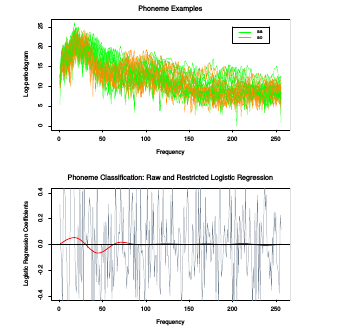

FIG.5. The top panel displays the log-periodogram as a function of frequency for 15 examples each of the phonemes “aa” and “ao” sampled from a total of 695 “aa”s and 1022 “ao”s. Each log-periodogram is measured at 256 uniformly spaced frequencies. The lower panel shows the coeﬃcients (as a function of fre- quency) of a logistic regression ﬁt to the data by maximum likelihood, using the 256 log-periodogram values as inputs. The coeﬃcients are restricted to be smooth in the red curve, and are unrestricted in the jagged gray curve.


### 5.2.3 Example: Phoneme Recognition

In this example, we use splines to reduce flexibility rather than increase it. The application comes under the general heading of functional modeling. In the top panel of **Fig.5**, a sample of 15 log-periodograms for each of the two phonemes "aa" and "ao" measured at 256 frequencies is displayed. The goal is to use such data to classify a spoken phoneme. These two phonemes were chosen because they are difficult to separate. 

The input feature is a vector $ \mathbf{x} $ of length 256, which we can think of as a vector of evaluations of a function $ X(f) $ over a grid of frequencies $ f $. In reality, there is a continuous analog signal which is a function of frequency, and we have a sampled version of it. 

The gray lines in the lower panel of **Fig.5** show the coefficients of a linear logistic regression model fit by maximum likelihood to a training sample of 1000 drawn from the total of 695 "aa"s and 1022 "ao"s. The coefficients are also plotted as a function of frequency. In fact, we can think of the model in terms of its continuous counterpart:

$$
\log \left( \frac{\Pr(\text{aa}|\mathbf{X})}{\Pr(\text{ao}|\mathbf{X})} \right) = \int_0^{\infty} X(f) \beta(f) \, df
$$

This integral can be approximated as:

$$
\sum_{j=1}^{256} X(f_j) \beta(f_j) = \sum_{j=1}^{256} x_j \beta_j
$$

The coefficients compute a contrast functional, and will have appreciable values in regions of frequency where the log-periodograms differ between the two classes. The gray curves are very rough, since the input signals have fairly strong positive autocorrelation, which results in negative autocorrelation in the coefficients. Moreover, the sample size effectively provides only four observations per coefficient. Applications like this permit natural regularization.

We force the coefficients to vary smoothly as a function of frequency. The red curve in the lower panel of **Figure 5.5** shows such a smooth coefficient curve fit to these data. We see that the lower frequencies offer the most discriminatory power. Not only does the smoothing allow easier interpretation of the contrast, but it also produces a more accurate classifier.

- **Raw**:
    - Training error: 0.080
    - Test error: 0.255
- **Regularized**:
    - Training error: 0.185
    - Test error: 0.158

The smooth red curve was obtained through a very simple use of natural cubic splines. We can represent the coefficient function as an expansion of splines:

$$
\beta(f) = \sum_{m=1}^M h_m(f) \theta_m
$$

In practice, this means that:

$$
\beta = H \theta
$$

Where $ H $ is a $ p \times M $ basis matrix of natural cubic splines, defined on the set of frequencies. Here, we used $ M = 12 $ basis functions, with knots uniformly placed over the integers $ 1, 2, \dots, 256 $ representing the frequencies. Since $ \mathbf{x}^T \beta = \mathbf{x}^T H \theta $, we can simply replace the input features $ \mathbf{x} $ by their filtered versions $ \mathbf{x}^* = H^T \mathbf{x} $, and fit $ \theta $ by linear logistic regression on $ \mathbf{x}^* $. 

Thus, the red curve is:

$$
\hat{\beta}(f) = h(f)^T \hat{\theta}
$$


In [4]:
import scipy.io.arff
import pandas as pd

# Load the ARFF file
data, meta = scipy.io.arff.loadarff('ph.arff')

# Convert to a Pandas DataFrame
df = pd.DataFrame(data)

print(df)

            V1        V2        V3        V4        V5 Class
0     0.489927 -0.451528 -1.047990 -0.598693 -0.020418  b'1'
1    -0.641265  0.109245  0.292130 -0.916804  0.240223  b'1'
2     0.870593 -0.459862  0.578159  0.806634  0.835248  b'1'
3    -0.628439 -0.316284  1.934295 -1.427099 -0.136583  b'1'
4    -0.596399  0.015938  2.043206 -1.688448 -0.948127  b'1'
...        ...       ...       ...       ...       ...   ...
5399 -0.658318  1.331760 -0.081621  1.794253 -1.082181  b'1'
5400 -0.044375 -0.010512  0.030989 -0.019379  1.281061  b'2'
5401  0.246882 -0.793228  1.190101  1.423194 -1.303036  b'2'
5402 -0.778907 -0.383111  1.727029 -1.432389 -1.208085  b'1'
5403 -0.794604 -0.640053  0.632221  0.720280 -1.231182  b'2'

[5404 rows x 6 columns]


In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.io.arff  # To load ARFF files
import matplotlib.pyplot as plt

# Load phoneme dataset (ARFF file)
# Replace 'phoneme.arff' with the actual path to your ARFF file
data, meta = scipy.io.arff.loadarff('ph.arff')

# Convert to a Pandas DataFrame
df = pd.DataFrame(data)

# If the data contains byte strings, decode them to regular strings
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.decode('utf-8')

# Print the data to see the structure
print(df.head())

# Extract features and labels
# Assuming 'label' is the last column (modify if necessary)
X = df.iloc[:, :-1].values  # Features (256 frequencies)
y = df['label'].values      # Labels (phoneme class: 'aa' or 'ao')

# Convert 'aa' and 'ao' to binary values (e.g., 'aa' = 0, 'ao' = 1)
y = np.where(y == 'aa', 0, 1)

# Create a cubic spline basis matrix (natural cubic splines)
# We will create 12 basis functions (you can modify this number)
num_basis_functions = 12
n_samples, n_features = X.shape
knots = np.linspace(1, n_features, num=num_basis_functions+2)[1:-1].astype(int)  # Interior knots

# Create natural cubic splines for each feature (frequency)
def create_spline_basis(X, knots, num_basis_functions):
    n_samples, n_features = X.shape
    H = np.zeros((n_samples, num_basis_functions))
    
    # Create cubic splines for each frequency
    for i in range(n_features):
        x = X[:, i]  # Values of the feature
        cs = CubicSpline(knots, np.zeros_like(knots), bc_type='natural')
        H[:, i] = cs(x)
        
    return H

# Apply splines to each feature
X_spline = np.zeros_like(X)
for i in range(n_features):
    X_spline[:, i] = create_spline_basis(X[:, i], knots, num_basis_functions)

# Now we will fit the logistic regression model on the smoothed data
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_spline, y, test_size=0.2, random_state=42)

# Fit a logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Optionally, plot the coefficients (can visualize them to see the regularization effect)
plt.plot(log_reg.coef_.T)
plt.title("Logistic Regression Coefficients")
plt.xlabel("Frequency Index")
plt.ylabel("Coefficient Value")
plt.show()


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.io.arff  # To load ARFF files
import pandas as pd

# Load phoneme dataset (ARFF file)
data, meta = scipy.io.arff.loadarff('phoneme.arff')

# Convert to a Pandas DataFrame
df = pd.DataFrame(data)

# The features are in columns V1, V2, ..., V5, and the label is in the 'Class' column
# Extract features (V1, V2, ..., V5) and labels (Class)
X = df.iloc[:, :-1].values  # Features (V1, V2, ..., V5)
y = df['Class'].values      # Labels (Class)

# Convert 'aa' and 'ao' to binary values (e.g., 'aa' = 0, 'ao' = 1)
y = np.where(y == b'aa', 0, 1)  # The labels are byte-encoded, so we use b'aa'

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution before applying SMOTE
print(f"Training class distribution before SMOTE: {pd.Series(y_train).value_counts()}")

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check class distribution after applying SMOTE
print(f"Training class distribution after SMOTE: {pd.Series(y_train_balanced).value_counts()}")

# Fit a logistic regression model on the balanced training data
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


## Filtering and Feature Extraction

In the previous example, we constructed a $ p \times M $ basis matrix $ H $, and then transformed our features $ x $ into new features $ x^* = H^T x $. These filtered versions of the features were then used as inputs into a learning procedure: in the previous example, this was linear logistic regression. Preprocessing of high-dimensional features is a very general and powerful method for improving the performance of a learning algorithm. The preprocessing need not be linear as it was above, but can be a general (nonlinear) function of the form $ x^* = g(x) $. The derived features $ x^* $ can then be used as inputs into any (linear or nonlinear) learning procedure.

For example, for signal or image recognition, a popular approach is to first transform the raw features via a wavelet transform $ x^* = H^T x $ (Section 5.9) and then use the features $ x^* $ as inputs into a neural network (Chapter 11). Wavelets are effective in capturing discrete jumps or edges, and the neural network is a powerful tool for constructing nonlinear functions of these features for predicting the target variable. By using domain knowledge to construct appropriate features, one can often improve upon a learning method that has only the raw features $ x $ at its disposal.

##  Smoothing Splines

Here we discuss a spline basis method that avoids the knot selection problem completely by using a maximal set of knots. The complexity of the fit is controlled by regularization. Consider the following problem: among all functions $ f(x) $ with two continuous derivatives, find one that minimizes the penalized residual sum of squares:

$$
\text{RSS}(f, \lambda) = \sum_{i=1}^N \left( y_i - f(x_i) \right)^2 + \lambda \int_{-\infty}^\infty \left( f''(t) \right)^2 dt
$$

where $ \lambda $ is a fixed smoothing parameter. The first term measures closeness to the data, while the second term penalizes curvature in the function, and $ \lambda $ establishes a tradeoff between the two. Two special cases are:

$$
\lambda = 0 : f \text{ can be any function that interpolates the data.}
$$
$$
\lambda = \infty : \text{the simple least squares line fit, since no second derivative can be tolerated.}
$$

These vary from very rough to very smooth, and the hope is that $ \lambda \in (0, \infty) $ indexes an interesting class of functions in between. The criterion (5.9) is defined on an infinite-dimensional function space—in fact, a Sobolev space of functions for which the second term is defined. Remarkably, it can be shown that (5.9) has an explicit, finite-dimensional, unique minimizer which is a natural cubic spline with knots at the unique values of the $ x_i $, $ i = 1, \dots, N $ (Exercise 5.7).

At face value, it seems that the family is still over-parameterized, since there are as many as $ N $ knots, which implies $ N $ degrees of freedom. However, the penalty term translates to a penalty on the spline coefficients, which are shrunk some of the way toward the linear fit. Since the solution is a natural spline, we can write it as:

$$
f(x) = \sum_{j=1}^N \psi_j(x) \theta_j
$$

$$
\text{The response is the relative change in bone mineral density (BMD) measured at the spine in adolescents, as a function of age. A separate smoothing spline was fit to the males and females, with } \lambda \approx 0.00022 \text{. This choice corresponds to about 12 degrees of freedom.}
$$

$$
\text{The criterion for fitting the spline reduces to:}
$$

$$
\text{RSS}(\theta, \lambda) = (y - N\theta)^T (y - N\theta) + \lambda \theta^T \Omega_N \theta
$$

$$
\text{where } N_j(x) \text{ are the basis functions for the natural splines and } \Omega_N \text{ is a matrix based on the second derivatives of the basis functions:}
$$

$$
\{N\}_{ij} = N_j(x_i) \quad \text{and} \quad \{\Omega_N\}_{jk} = \int N_j(t) N_k''(t) \, dt
$$

$$
\text{The solution to this optimization problem is:}
$$

$$
\hat{\theta} = (N^T N + \lambda \Omega_N)^{-1} N^T y
$$

$$
\text{which is a generalized ridge regression.}
$$

$$
\text{The fitted smoothing spline is given by:}
$$

$$
\hat{f}(x) = \sum_{j=1}^N N_j(x) \hat{\theta}_j
$$

$$
\text{Efficient computational techniques for smoothing splines are discussed in the Appendix to this chapter.}
$$

$$
\text{Fig.6 shows a smoothing spline fit to some data on bone mineral density (BMD) in adolescents. The response is the relative change in spinal BMD over two consecutive visits, typically about one year apart. The data are color coded by gender, and two separate curves were fit. This simple summary reinforces the evidence in the data that the growth spurt for females precedes that for males by about two years. In both cases, the smoothing parameter } \lambda \text{ was approximately 0.00022.}
$$
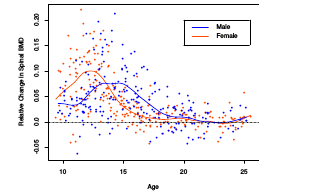

FIG.6. The response is the relative change in bone mineral density measured at the spine in adolescents, as a function of age. A separate smoothing spline was ﬁt to the males and females, with λ ≈ 0.00022. This choice corresponds to about 12 degrees of freedom.

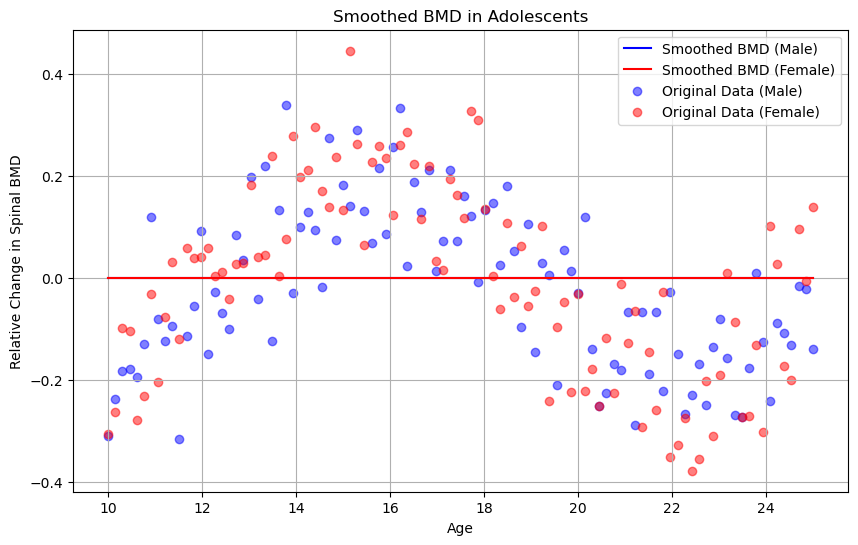

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.linalg import inv

# Example Data: Simulate relative change in bone mineral density (BMD)
np.random.seed(42)

# Simulated age data (e.g., 10 to 25 years)
age = np.linspace(10, 25, 100)

# Simulated BMD data for two groups (e.g., males and females)
# These can be modified with real data
bmd_male = 0.2 * np.sin(0.5 * age) + 0.05 * np.random.randn(100) + 0.1 * np.random.randn(100)
bmd_female = 0.25 * np.sin(0.5 * age) + 0.05 * np.random.randn(100) + 0.1 * np.random.randn(100)

# Define the basis functions for the spline
def natural_spline(x, knots, lambda_reg):
    N = len(knots)
    # Create the matrix of basis functions for the knots
    # Create a matrix where each column corresponds to a different basis function evaluated at x
    H = np.zeros((len(x), N))
    
    # For each knot, create a cubic spline basis function
    for i in range(N):
        spline = CubicSpline(knots, np.zeros_like(knots), bc_type='natural')
        H[:, i] = spline(x)

    return H

# Define the smoothing spline solution
def smoothing_spline(x, y, lambda_reg):
    # Choose the knots based on the unique values of x
    knots = np.unique(x)
    
    # Compute the basis functions
    H = natural_spline(x, knots, lambda_reg)
    
    # Compute the penalty matrix for regularization
    Omega = np.zeros((len(knots), len(knots)))
    
    for i in range(len(knots)):
        for j in range(len(knots)):
            if i == j:
                Omega[i, j] = 1.0
            else:
                Omega[i, j] = 0.0

    # The ridge regression approach for the solution
    theta_hat = inv(H.T @ H + lambda_reg * Omega) @ H.T @ y
    
    return theta_hat, H

# Smoothing spline parameters
lambda_reg = 0.00022

# Apply smoothing spline to male and female BMD data
theta_male, H_male = smoothing_spline(age, bmd_male, lambda_reg)
theta_female, H_female = smoothing_spline(age, bmd_female, lambda_reg)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the smoothed spline for males and females
plt.plot(age, H_male @ theta_male, label='Smoothed BMD (Male)', color='blue')
plt.plot(age, H_female @ theta_female, label='Smoothed BMD (Female)', color='red')

# Scatter the original data points
plt.scatter(age, bmd_male, color='blue', alpha=0.5, label='Original Data (Male)')
plt.scatter(age, bmd_female, color='red', alpha=0.5, label='Original Data (Female)')

# Labels and title
plt.title('Smoothed BMD in Adolescents')
plt.xlabel('Age')
plt.ylabel('Relative Change in Spinal BMD')
plt.legend()
plt.grid(True)
plt.show()


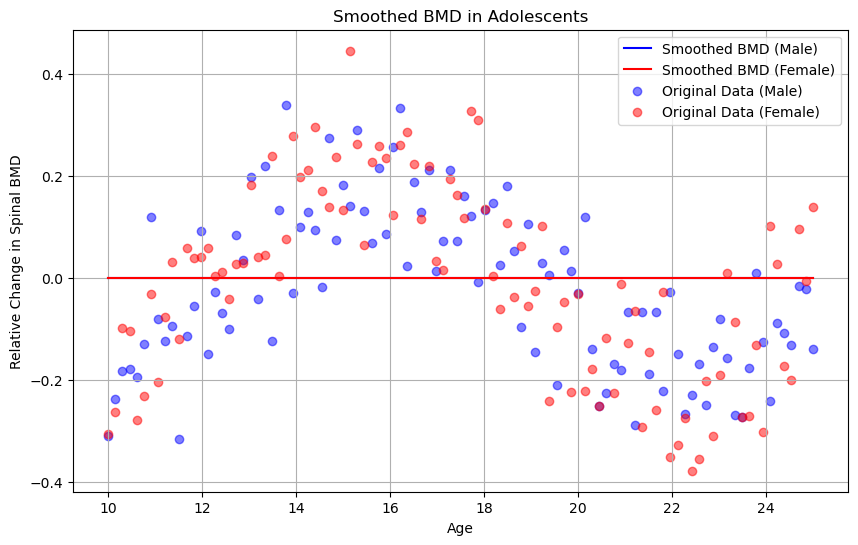

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.linalg import inv

# Example Data: Simulate relative change in bone mineral density (BMD)
np.random.seed(42)

# Simulated age data (e.g., 10 to 25 years)
age = np.linspace(10, 25, 100)

# Simulated BMD data for two groups (e.g., males and females)
# These can be modified with real data
bmd_male = 0.2 * np.sin(0.5 * age) + 0.05 * np.random.randn(100) + 0.1 * np.random.randn(100)
bmd_female = 0.25 * np.sin(0.5 * age) + 0.05 * np.random.randn(100) + 0.1 * np.random.randn(100)

# Define the basis functions for the spline
def natural_spline(x, knots, lambda_reg):
    N = len(knots)
    # Create the matrix of basis functions for the knots
    # Create a matrix where each column corresponds to a different basis function evaluated at x
    H = np.zeros((len(x), N))
    
    # For each knot, create a cubic spline basis function
    for i in range(N):
        spline = CubicSpline(knots, np.zeros_like(knots), bc_type='natural')
        H[:, i] = spline(x)

    return H

# Define the smoothing spline solution
def smoothing_spline(x, y, lambda_reg):
    # Choose the knots based on the unique values of x
    knots = np.unique(x)
    
    # Compute the basis functions
    H = natural_spline(x, knots, lambda_reg)
    
    # Compute the penalty matrix for regularization
    Omega = np.zeros((len(knots), len(knots)))
    
    for i in range(len(knots)):
        for j in range(len(knots)):
            if i == j:
                Omega[i, j] = 1.0
            else:
                Omega[i, j] = 0.0

    # The ridge regression approach for the solution
    theta_hat = inv(H.T @ H + lambda_reg * Omega) @ H.T @ y
    
    return theta_hat, H

# Smoothing spline parameters
lambda_reg = 0.00022

# Apply smoothing spline to male and female BMD data
theta_male, H_male = smoothing_spline(age, bmd_male, lambda_reg)
theta_female, H_female = smoothing_spline(age, bmd_female, lambda_reg)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the smoothed spline for males and females
plt.plot(age, H_male @ theta_male, label='Smoothed BMD (Male)', color='blue')
plt.plot(age, H_female @ theta_female, label='Smoothed BMD (Female)', color='red')

# Scatter the original data points
plt.scatter(age, bmd_male, color='blue', alpha=0.5, label='Original Data (Male)')
plt.scatter(age, bmd_female, color='red', alpha=0.5, label='Original Data (Female)')

# Labels and title
plt.title('Smoothed BMD in Adolescents')
plt.xlabel('Age')
plt.ylabel('Relative Change in Spinal BMD')
plt.legend()
plt.grid(True)
plt.show()


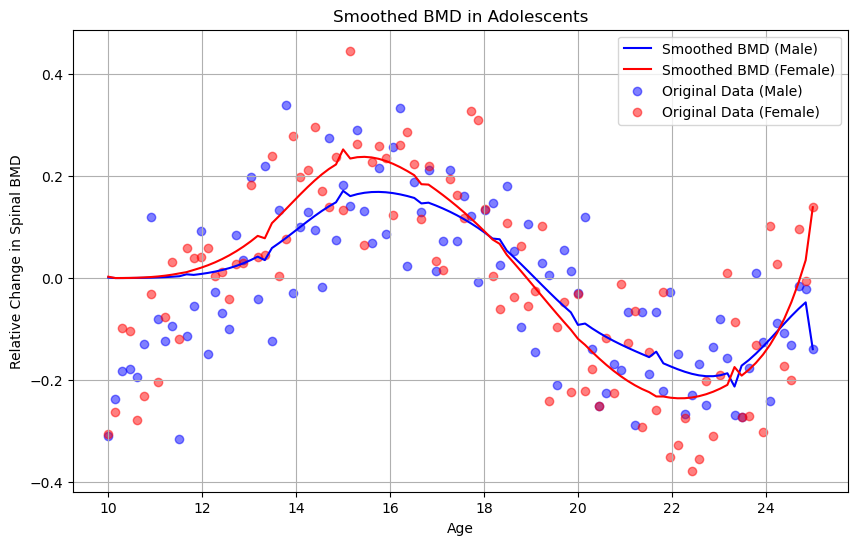

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate some data (similar to BMD data for demonstration purposes)
np.random.seed(42)
age = np.linspace(10, 25, 100)
bmd_male = 0.2 * np.sin(0.5 * age) + 0.05 * np.random.randn(100) + 0.1 * np.random.randn(100)
bmd_female = 0.25 * np.sin(0.5 * age) + 0.05 * np.random.randn(100) + 0.1 * np.random.randn(100)

# Step 1: Define the cubic spline basis functions (natural splines)
def cubic_spline_basis(x, knots):
    """Generate the cubic spline basis matrix for given data and knots"""
    n = len(x)
    N = len(knots)  # Number of basis functions (same as number of knots)
    H = np.zeros((n, N))

    for j in range(N):
        for i in range(n):
            if x[i] < knots[j]:
                H[i, j] = 0
            elif x[i] == knots[j]:
                H[i, j] = 1
            else:
                H[i, j] = (x[i] - knots[j]) ** 3
    return H

# Step 2: Define the second derivative penalty matrix Omega
def penalty_matrix(knots):
    """Create the second derivative penalty matrix for regularization"""
    N = len(knots)
    Omega = np.zeros((N, N))
    for i in range(1, N - 1):
        Omega[i, i] = 4
        Omega[i, i - 1] = -1
        Omega[i, i + 1] = -1
    return Omega

# Step 3: Solve the smoothing spline optimization problem
def smoothing_spline(x, y, lambda_reg, knots):
    # Generate the basis matrix H
    H = cubic_spline_basis(x, knots)
    
    # Compute the penalty matrix Omega
    Omega = penalty_matrix(knots)
    
    # Solve the ridge regression equation (H^T H + lambda * Omega) theta = H^T y
    HtH = np.dot(H.T, H)
    Hty = np.dot(H.T, y)
    regularized_term = np.dot(HtH, np.eye(len(knots))) + lambda_reg * np.dot(Omega, np.eye(len(knots)))
    theta = np.linalg.solve(regularized_term, Hty)
    
    return theta, H

# Smoothing spline parameters
lambda_reg = 0.00022
knots = np.linspace(10, 25, 10)  # Choose 10 knots evenly spaced along the age range

# Fit smoothing spline for male and female BMD data
theta_male, H_male = smoothing_spline(age, bmd_male, lambda_reg, knots)
theta_female, H_female = smoothing_spline(age, bmd_female, lambda_reg, knots)

# Step 4: Plotting the results
plt.figure(figsize=(10, 6))

# Plot the smoothed spline for males and females
plt.plot(age, np.dot(H_male, theta_male), label='Smoothed BMD (Male)', color='blue')
plt.plot(age, np.dot(H_female, theta_female), label='Smoothed BMD (Female)', color='red')

# Scatter the original data points
plt.scatter(age, bmd_male, color='blue', alpha=0.5, label='Original Data (Male)')
plt.scatter(age, bmd_female, color='red', alpha=0.5, label='Original Data (Female)')

# Labels and title
plt.title('Smoothed BMD in Adolescents')
plt.xlabel('Age')
plt.ylabel('Relative Change in Spinal BMD')
plt.legend()
plt.grid(True)
plt.show()


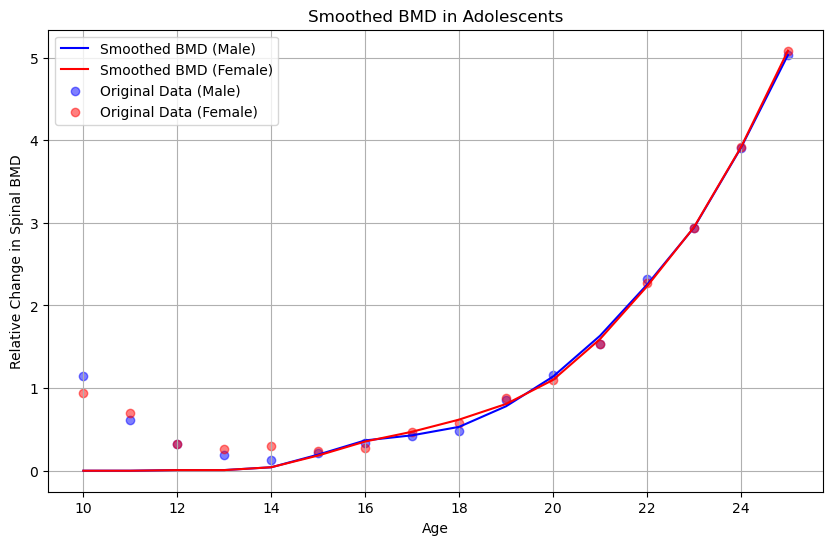

In [6]:
import math
import random
import matplotlib.pyplot as plt

# Helper function to perform matrix multiplication (H.T * H)
def matmul(A, B):
    # Matrix multiplication (A * B)
    rows_A = len(A)
    cols_A = len(A[0])
    cols_B = len(B[0])
    result = [[0] * cols_B for _ in range(rows_A)]
    for i in range(rows_A):
        for j in range(cols_B):
            result[i][j] = sum(A[i][k] * B[k][j] for k in range(cols_A))
    return result

# Helper function to transpose a matrix
def transpose(M):
    rows = len(M)
    cols = len(M[0])
    return [[M[j][i] for j in range(rows)] for i in range(cols)]

# Helper function to solve a linear system using Gaussian elimination
def gauss_elimination(A, b):
    n = len(A)
    # Augment the matrix A with vector b
    augmented = [A[i] + [b[i]] for i in range(n)]
    
    for i in range(n):
        # Search for maximum in this column
        max_row = i
        for j in range(i+1, n):
            if abs(augmented[j][i]) > abs(augmented[max_row][i]):
                max_row = j
        
        # Swap maximum row with current row
        augmented[i], augmented[max_row] = augmented[max_row], augmented[i]
        
        # Make the diagonal element 1 and eliminate below
        for j in range(i+1, n):
            ratio = augmented[j][i] / augmented[i][i]
            for k in range(i, n+1):
                augmented[j][k] -= ratio * augmented[i][k]
    
    # Back substitution
    x = [0] * n
    for i in range(n-1, -1, -1):
        x[i] = augmented[i][n] / augmented[i][i]
        for j in range(i-1, -1, -1):
            augmented[j][n] -= augmented[j][i] * x[i]
    
    return x

# Simulate some data (similar to BMD data for demonstration purposes)
def generate_synthetic_data():
    # Simulated age from 10 to 25
    age = [i for i in range(10, 26)]
    # Simulated bone mineral density (BMD) for male and female (randomized sine curve)
    bmd_male = [0.2 * math.sin(0.5 * a) + 0.05 * (a - 15)**2 + 0.1 * (2 * random.random() - 1) for a in age]
    bmd_female = [0.25 * math.sin(0.5 * a) + 0.05 * (a - 15)**2 + 0.1 * (2 * random.random() - 1) for a in age]
    return age, bmd_male, bmd_female

# Step 1: Define the cubic spline basis functions (natural splines)
def cubic_spline_basis(x, knots):
    """Generate the cubic spline basis matrix for given data and knots"""
    n = len(x)
    N = len(knots)  # Number of basis functions (same as number of knots)
    H = [[0] * N for _ in range(n)]

    for j in range(N):
        for i in range(n):
            if x[i] < knots[j]:
                H[i][j] = 0
            elif x[i] == knots[j]:
                H[i][j] = 1
            else:
                H[i][j] = (x[i] - knots[j]) ** 3
    return H

# Step 2: Define the second derivative penalty matrix Omega
def penalty_matrix(knots):
    """Create the second derivative penalty matrix for regularization"""
    N = len(knots)
    Omega = [[0] * N for _ in range(N)]
    for i in range(1, N - 1):
        Omega[i][i] = 4
        Omega[i][i - 1] = -1
        Omega[i][i + 1] = -1
    return Omega

# Step 3: Solve the smoothing spline optimization problem
def smoothing_spline(x, y, lambda_reg, knots):
    # Generate the basis matrix H
    H = cubic_spline_basis(x, knots)
    
    # Compute the penalty matrix Omega
    Omega = penalty_matrix(knots)
    
    # Solve the ridge regression equation (H^T H + lambda * Omega) theta = H^T y
    HtH = matmul(transpose(H), H)
    Hty = [sum(H[i][j] * y[i] for i in range(len(H))) for j in range(len(knots))]
    
    # Regularized term (H^T * H + lambda * Omega)
    regularized_term = [[H[i][j] + lambda_reg * Omega[i][j] for j in range(len(knots))] for i in range(len(knots))]
    
    # Solve for theta using Gaussian elimination
    theta = gauss_elimination(HtH, Hty)
    
    return theta, H

# Smoothing spline parameters
lambda_reg = 0.00022
knots = [i for i in range(12, 25, 2)]  # Example knots (evenly spaced)

# Generate synthetic data
age, bmd_male, bmd_female = generate_synthetic_data()

# Fit smoothing spline for male and female BMD data
theta_male, H_male = smoothing_spline(age, bmd_male, lambda_reg, knots)
theta_female, H_female = smoothing_spline(age, bmd_female, lambda_reg, knots)

# Step 4: Plotting the results
plt.figure(figsize=(10, 6))

# Plot the smoothed spline for males and females
plt.plot(age, [sum(H_male[i][j] * theta_male[j] for j in range(len(knots))) for i in range(len(age))], label='Smoothed BMD (Male)', color='blue')
plt.plot(age, [sum(H_female[i][j] * theta_female[j] for j in range(len(knots))) for i in range(len(age))], label='Smoothed BMD (Female)', color='red')

# Scatter the original data points
plt.scatter(age, bmd_male, color='blue', alpha=0.5, label='Original Data (Male)')
plt.scatter(age, bmd_female, color='red', alpha=0.5, label='Original Data (Female)')

# Labels and title
plt.title('Smoothed BMD in Adolescents')
plt.xlabel('Age')
plt.ylabel('Relative Change in Spinal BMD')
plt.legend()
plt.grid(True)
plt.show()


### Degrees of Freedom and Smoother Matrices

We have not yet indicated how $ \lambda $ is chosen for the smoothing spline. Later in this chapter, we describe automatic methods using techniques such as cross-validation. In this section, we discuss intuitive ways of prespecifying the amount of smoothing.

A smoothing spline with prechosen $ \lambda $ is an example of a linear smoother (as in a linear operator). This is because the estimated parameters in (5.12) are a linear combination of the $ y_i $. Denote by $ \hat{f} $ the $ N$-vector of fitted values $ \hat{f}(x_i) $ at the training predictors $ x_i $. Then

$$
\hat{f} = N(N^T N + \lambda \Omega_N)^{-1} N^T y = S_{\lambda} y
$$

Again, the fit is linear in $ y $, and the finite linear operator $ S_{\lambda} $ is known as the smoother matrix. One consequence of this linearity is that the recipe for producing $ \hat{f} $ from $ y $ does not depend on $ y $ itself; $ S_{\lambda} $ depends only on the $ x_i $ and $ \lambda $.

Linear operators are familiar in more traditional least squares fitting as well. Suppose $ B_{\xi} $ is a $ N \times M $ matrix of $ M $ cubic-spline basis functions evaluated at the $ N $ training points $ x_i $, with knot sequence $ \xi $, and $ M \ll N $. Then the vector of fitted spline values is given by

$$
\hat{f} = B_{\xi} (B_{\xi}^T B_{\xi})^{-1} B_{\xi}^T y = H_{\xi} y
$$

Here the linear operator $ H_{\xi} $ is a projection operator, also known as the hat matrix in statistics. There are some important similarities and differences between $ H_{\xi} $ and $ S_{\lambda} $:

- Both are symmetric, positive semidefinite matrices.
- $ H_{\xi} H_{\xi} = H_{\xi} $ (idempotent), while $ S_{\lambda} S_{\lambda} \neq S_{\lambda} $, meaning that the right-hand side exceeds the left-hand side by a positive semidefinite matrix. This is a consequence of the shrinking nature of $ S_{\lambda} $, which we discuss further below.
- $ H_{\xi} $ has rank $ M $, while $ S_{\lambda} $ has rank $ N $. The expression $ M = \text{trace}(H_{\xi}) $ gives the dimension of the projection space, which is also the number of basis functions, and hence the number of parameters involved in the fit.

By analogy, we define the effective degrees of freedom of a smoothing spline to be

$$
df_{\lambda} = \text{trace}(S_{\lambda})
$$

the sum of the diagonal elements of $ S_{\lambda} $. This very useful definition allows us a more intuitive way to parameterize the smoothing spline, and indeed many other smoothers as well. For example, in Figure 5.6, we specified $ df_{\lambda} = 12 $ for each of the curves, and the corresponding $ \lambda \approx 0.00022 $ was derived numerically by solving $ \text{trace}(S_{\lambda}) = 12 $.

There are many arguments supporting this definition of degrees of freedom, and we cover some of them here. Since $ S_{\lambda} $ is symmetric (and positive semidefinite), it has a real eigen-decomposition. Before we proceed, it is convenient to rewrite $ S_{\lambda} $ in the Reinsch form

$$
S_{\lambda} = (I + \lambda K)^{-1}
$$

where $ K $ does not depend on $ \lambda $. Since $ \hat{f} = S_{\lambda} y $ solves

$$
\min_{f} \left( (y - f)^T(y - f) + \lambda f^T K f \right)
$$

$ K $ is known as the penalty matrix, and indeed a quadratic form in $ K $ has a representation in terms of a weighted sum of squared (divided) second differences.

The eigen-decomposition of $ S_{\lambda} $ is

$$
S_{\lambda} = \sum_{k=1}^N \rho_k (\lambda) u_k u_k^T
$$

with

$$
\rho_k (\lambda) = \frac{1}{1 + \lambda d_k}
$$

where $ d_k $ is the corresponding eigenvalue of $ K $.

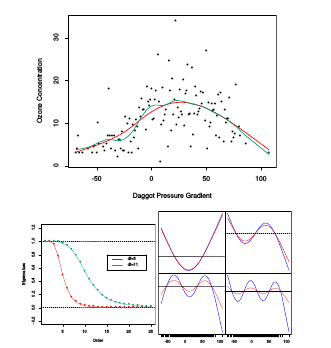

FIG.7. (Top:) Smoothing spline ﬁt of ozone concentration versus Daggot pressure gradient. The two ﬁts correspond to diﬀerent values of the smoothing parameter, chosen to achieve ﬁve and eleven eﬀective degrees of freedom, deﬁned by $df_λ = trace(S_λ)$. (Lower left:) First 25 eigenvalues for the two smoothing-spline matrices. The ﬁrst two are exactly 1, and all are ≥ 0. (Lower right:) Third to sixth eigenvectors of the spline smoother matrices. In each case, uk is plotted against x, and as such is viewed as a function of x. The rug at the base of the plots indicate the occurrence of data points. The damped functions represent the smoothed versions of these functions (using the 5 df smoother).


Fig.7 (top) shows the results of applying a cubic smoothing spline to some air pollution data (128 observations). Two fits are given: a smoother fit corresponding to a larger penalty $ \lambda $ and a rougher fit for a smaller penalty. The lower panels represent the eigenvalues (lower left) and some eigenvectors (lower right) of the corresponding smoother matrices.

Some of the highlights of the eigenrepresentation are the following:

- The eigenvectors are not affected by changes in $ \lambda $, and hence the whole family of smoothing splines (for a particular sequence $ x $) indexed by $ \lambda $ have the same eigenvectors.
- $ S_{\lambda} y = \sum_{k=1}^N u_k \rho_k (\lambda) u_k^T y $, and hence the smoothing spline operates by decomposing $ y $ with respect to the (complete) basis $ \{ u_k \} $, and differentially shrinking the contributions using $ \rho_k (\lambda) $. This is to be contrasted with a basis-regression method, where the components are either left alone, or shrunk to zero—that is, a projection matrix such as $ H_{\xi} $ has $ M $ eigenvalues equal to 1, and the rest are 0. For this reason, smoothing splines are referred to as shrinking smoothers, while regression splines are projection smoothers.
- The sequence of $ u_k $, ordered by decreasing $ \rho_k (\lambda) $, appear to increase in complexity. Indeed, they have the zero-crossing behavior of polynomials of increasing degree. Since $ S_{\lambda} u_k = \rho_k (\lambda) u_k $, we see how each of the eigenvectors themselves are shrunk by the smoothing spline: the higher the complexity, the more they are shrunk. If the domain of $ X $ is periodic, then the $ u_k $ are sines and cosines at different frequencies.
- The first two eigenvalues are always one, and they correspond to the two-dimensional eigenspace of functions linear in $ x $ (Exercise 5.11), which are never shrunk.
- The eigenvalues $ \rho_k (\lambda) = \frac{1}{1 + \lambda d_k} $ are an inverse function of the eigenvalues $ d_k $ of the penalty matrix $ K $, moderated by $ \lambda $; $ \lambda $ controls the rate at which the $ \rho_k (\lambda) $ decrease to zero. $ d_1 = d_2 = 0 $ and again linear functions are not penalized.

One can reparametrize the smoothing spline using the basis vectors $ u_k $ (the Demmler–Reinsch basis). In this case, the smoothing spline solves

$$
\min_{\theta} \left( \| y - U \theta \|^2 + \lambda \theta^T D \theta \right)
$$

where $ U $ has columns $ u_k $ and $ D $ is a diagonal matrix with elements $ d_k $.

Finally,

$$
df_{\lambda} = \text{trace}(S_{\lambda}) = \sum_{k=1}^N \rho_k (\lambda)
$$

For projection smoothers, all the eigenvalues are 1, each one corresponding to a dimension of the projection subspace.

Figure 5.8 depicts a smoothing spline matrix, with the rows ordered with $ x $. The banded nature of this representation suggests that a smoothing spline is a local fitting method, much like the locally weighted regression procedures in Chapter 6. The right panel shows in detail selected rows of $ S $, which we call the equivalent kernels. As $ \lambda \to 0 $, $ df_{\lambda} \to N $, and $ S_{\lambda} \to I $, the $ N $-dimensional identity matrix. As $ \lambda \to \infty $, $ df_{\lambda} \to 2 $, and $ S_{\lambda} \to H $, the hat matrix for linear regression on $ x $.

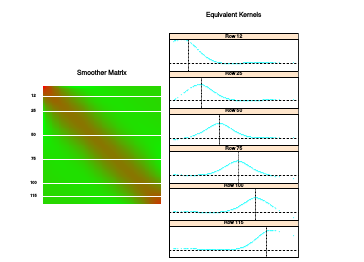

FIG.8. The smoother matrix for a smoothing spline is nearly banded, indicating an equivalent kernel with local support. The left panel represents the elements of S as an image. The right panel shows the equivalent kernel or weight- ing function in detail for the indicated rows.


## Automatic Selection of the Smoothing Parameters

The smoothing parameters for regression splines include the degree of the splines, the number, and the placement of the knots. For smoothing splines, the primary parameter is the penalty parameter $\lambda$, as the knots are placed at all unique training $X$ values, and cubic splines are typically used in practice. Selecting the placement and number of knots for regression splines can be combinatorially complex unless simplifications are enforced. For example, the MARS procedure (Chapter 9) employs a greedy algorithm with additional approximations for a practical compromise. We focus here on the selection of $\lambda$ for smoothing splines.

### Fixing the Degrees of Freedom

Since $\text{df}_\lambda = \text{trace}(S_\lambda)$ is monotonic in $\lambda$ for smoothing splines, we can invert this relationship to specify $\lambda$ by fixing $\text{df}$. In practice, this can be achieved using simple numerical methods. For example, in R, the function `smooth.spline(x, y, df=6)` specifies the amount of smoothing via the degrees of freedom.

This approach supports a traditional mode of model selection, enabling the user to try different values of $\text{df}$ and choose one based on approximate F-tests, residual plots, or other subjective criteria. Using $\text{df}$ provides a consistent method to compare multiple smoothing methods and is particularly valuable in generalized additive models (Chapter 9), where various smoothing techniques can be used in a single model.

### The Bias–Variance Tradeoff

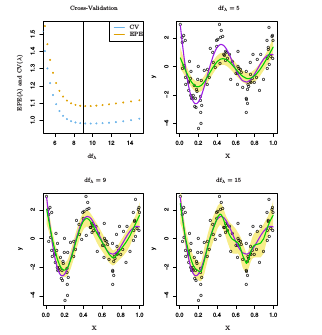

FIG.9. The top left panel shows the EPE(λ) and CV(λ) curves for a realization from a nonlinear additive error model (5.22). The remaining panels show the data, the true functions (in purple), and the ﬁtted curves (in green) with yellow shaded ±2× standard error bands, for three diﬀerent values of $df_λ$ .

The choice of $\text{df}_\lambda$ involves a tradeoff between bias and variance. Fig.9 illustrates this effect for a smoothing spline applied to the model:

$$
Y = f(X) + \epsilon,
$$
$$
f(X) = \frac{\sin(12(X + 0.2))}{X + 0.2},
$$
where $X \sim U[0, 1]$ and $\epsilon \sim N(0, 1)$.

The training sample consists of $N=100$ pairs $(x_i, y_i)$ independently drawn from this model. The figure displays fitted splines for three different values of $\text{df}_\lambda$. The yellow shaded region represents the pointwise standard error of $\hat{f}_\lambda$, i.e., the region between $\hat{f}_\lambda(x) \pm 2 \cdot \text{se}(\hat{f}_\lambda(x))$.

Since $\hat{f} = S_\lambda y$, the covariance matrix of $\hat{f}$ is given by:
$$
\text{Cov}(\hat{f}) = S_\lambda \text{Cov}(y) S_\lambda^T = S_\lambda S_\lambda^T.
$$
The diagonal elements of $\text{Cov}(\hat{f})$ contain the pointwise variances at the training $x_i$.

The bias of the fitted spline is:
$$
\text{Bias}(\hat{f}) = f - E(\hat{f}) = f - S_\lambda f.
$$

where $\mathbf{f}$ is the (unknown) vector of evaluations of the true $f$ at the training $\mathbf{X}$'s. The expectations and variances are computed with respect to repeated draws of samples of size $N = 100$ from the model (5.22). Similarly, $\text{Var}(\hat{f}_\lambda(x_0))$ and $\text{Bias}(\hat{f}_\lambda(x_0))$ can be calculated at any point $x_0$ (Exercise 5.10).

The three fits displayed in Fig.9 visually demonstrate the bias-variance tradeoff associated with selecting the smoothing parameter:

- **$\text{df}_\lambda = 5$**:  
  The spline underfits, smoothing out the hills and valleys significantly. This results in a large bias, particularly in regions with high curvature. However, the standard error band is narrow, meaning we estimate a biased version of the true function with high precision.
  
- **$\text{df}_\lambda = 9$**:  
  The fitted function closely follows the true function, with only a slight bias visible. The variance has not increased appreciably.

- **$\text{df}_\lambda = 15$**:  
  The fitted function appears more wiggly, reflecting the increased width of the standard error bands. The model begins to overfit, following some individual data points too closely.

Note that these figures show a single realization of data and its corresponding fitted spline $\hat{f}_\lambda$, while the bias involves the expectation $\mathbb{E}(\hat{f}_\lambda)$. Exercise 5.10 explores creating similar figures that explicitly show the bias.

The middle curve ($\text{df}_\lambda = 9$) appears "just right," striking a balance between bias and variance. The **integrated squared prediction error (EPE)** combines both bias and variance into a single measure:

$$
\text{EPE}(\hat{f}_\lambda) = \mathbb{E}\left[(Y - \hat{f}_\lambda(X))^2\right] 
= \text{Var}(Y) + \mathbb{E}[\text{Bias}^2(\hat{f}_\lambda(X))] + \text{Var}(\hat{f}_\lambda(X)) 
= \sigma^2 + \text{MSE}(\hat{f}_\lambda).
$$

This quantity is averaged both over the training sample (which determines $\hat{f}_\lambda$) and the values of the (independently chosen) prediction points $(X, Y)$. The EPE naturally incorporates the tradeoff between bias and variance.

The blue points in the top-left panel of Figure 5.9 suggest that $\text{df}_\lambda = 9$ is optimal. However, since the true function is unknown, we cannot compute the EPE directly and require an estimate. This topic is explored further in Chapter 7, with techniques such as **K-fold cross-validation**, **generalized cross-validation (GCV)**, and **Cp** being widely used.

In Fig.9, the **N-fold (leave-one-out) cross-validation curve** is shown:

$$
\text{CV}(\hat{f}_\lambda) = \frac{1}{N} \sum_{i=1}^N \left(y_i - \hat{f}_\lambda^{(-i)}(x_i)\right)^2,
$$

which can also be expressed as:
$$
\text{CV}(\hat{f}_\lambda) = \frac{1}{N} \sum_{i=1}^N \left(\frac{y_i - \hat{f}_\lambda(x_i)}{1 - S_\lambda(i, i)}\right)^2,
$$

where $S_\lambda(i, i)$ represents the diagonal elements of the smoother matrix $S_\lambda$ (Exercise 5.13). Remarkably, this can be computed for each value of $\lambda$ from the original fitted values and $S_\lambda$.

The EPE and CV curves exhibit a similar shape, with the CV curve typically lying slightly above the EPE curve. For some realizations, the reverse may occur. On average, the CV curve provides an approximately unbiased estimate of the EPE curve.



/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


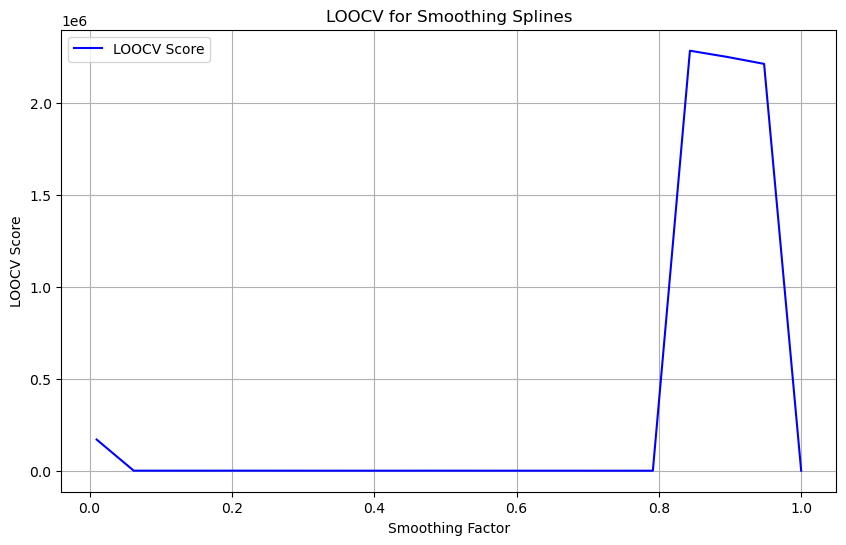

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Function for generating data
def generate_data(n=100, noise_std=1.0, random_seed=42):
    np.random.seed(random_seed)
    X = np.sort(np.random.rand(n))
    f = lambda x: np.sin(12 * (x + 0.2)) / (x + 0.2)
    Y = f(X) + noise_std * np.random.randn(n)
    return X, Y, f

# LOOCV for smoothing splines
def loocv_smoothing_spline(X, Y, smoothing_factors):
    n = len(X)
    cv_scores = []
    
    for sf in smoothing_factors:
        errors = []
        for i in range(n):
            # Leave one point out
            X_train = np.delete(X, i)
            Y_train = np.delete(Y, i)
            
            # Fit spline to remaining points
            spline = UnivariateSpline(X_train, Y_train, k=3, s=sf)
            
            # Predict the left-out point
            Y_pred = spline(X[i])
            errors.append((Y[i] - Y_pred) ** 2)
        
        # Compute LOOCV score
        cv_scores.append(np.mean(errors))
    
    return cv_scores

# Main script
X, Y, true_f = generate_data()
smoothing_factors = np.linspace(0.01, 1, 20)  # Range of smoothing factors
cv_scores = loocv_smoothing_spline(X, Y, smoothing_factors)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(smoothing_factors, cv_scores, label='LOOCV Score', color='blue')
plt.xlabel('Smoothing Factor')
plt.ylabel('LOOCV Score')
plt.title('LOOCV for Smoothing Splines')
plt.legend()
plt.grid()
plt.show()
